In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [29]:
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import sophius.utils as utils
import sophius.dataload as dload
from sophius.modelgen import ConvModelGenerator
from sophius.train import train_express_gpu
import torchvision.datasets as dset
import torchvision.transforms as T
from sophius.encode import Encoder


VAL_SIZE = 1024

cifar10 = dset.CIFAR10('../data/CIFAR10', train=True, download=True, transform=T.ToTensor())
cifar_gpu = dload.cifar_to_gpu(cifar10)
loader_gpu = dload.get_loader_gpu(cifar_gpu, val_size=VAL_SIZE, batch_size=1024)

encoder = Encoder()

Files already downloaded and verified


In [32]:
def check_accuracy(model, loader):
    num_correct = 0
    num_samples = 0
    model.eval()  # Put the model in test mode (the opposite of model.train(), essentially)
    with torch.no_grad():
        for x, y in loader:
            x_var = x.type(torch.cuda.FloatTensor)
            y_var = y.type(torch.LongTensor)
            scores = model(x_var)
            _, preds = scores.data.cpu().max(1)
            num_correct += (preds == y_var).sum()
            num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
#     print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc


def check_accuracy_gpu(model, loader):
    num_correct = 0
    num_samples = 0
    model.eval()  # Put the model in test mode (the opposite of model.train(), essentially)
    with torch.no_grad():
        for x, y in loader:
            scores = model(x)
            _, preds = scores.data.cuda().max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
#     print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

def train_express_gpu(model=None,
                      loader=None,
                      num_epoch=1,
                      milestones=None,
                      train=False,
                      manual_seed=False,
                      verbose=False):
    if milestones is None:
        milestones = []

    start_time = time.time()
    
    if manual_seed:
        torch.cuda.random.manual_seed(12345)
    # init
    loss_fn = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
    model.apply(utils.reset)
    model.train()

    train_acc, val_acc = 0, 0

    res = pd.DataFrame(columns=['epoch', 'train_acc', 'val_acc', 'time'])

    for i in range(num_epoch):
        model.train()
        for t, (x, y) in enumerate(loader['train']):
            scores = model(x)
            loss = loss_fn(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()
        
        _val_acc = check_accuracy(model, loader['val'])
        _train_acc = check_accuracy(model, loader['train_small'])
        res.loc[i] = [i, _train_acc, _val_acc, time.time() - start_time]
        
        
    val_acc = check_accuracy(model, loader['val'])
    if train: 
        train_acc = check_accuracy(model, loader['train_small'])

    time_elapsed = (time.time() - start_time)

    if verbose:
        print ('Finished in %s' % utils.format_time(time_elapsed))
        print('val_acc: %.3f, train_acc: %.3f' % (val_acc, train_acc))
    
    torch.cuda.empty_cache()
    del model
    
    return res

In [14]:
model_gen = ConvModelGenerator((3, 32, 32), 10, conv_num=6, lin_num=3)

model_tmpl = model_gen.generate_model_tmpl()
model = model_tmpl.instantiate_model().type(torch.cuda.FloatTensor)

In [16]:
model

Sequential(
  (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
  (1): PReLU(num_parameters=1)
  (2): Conv2d(8, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  (3): PReLU(num_parameters=1)
  (4): MaxPool2d(kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), dilation=(1, 1), ceil_mode=False)
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): AvgPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): AvgPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=64, out_features=32, bias=True)
  (10): PReLU(num_parameters=32)
  (11): Dropout(p=0.7, inplace=False)
  (12): Linear(in_features=32, out_features=32, bias=True)
  (13): PReLU(num_parameters=32)
  (14): Dropout(p=0.1, inplace=False)
  (15): Linear(in_features=32, out_features=10, bias=True)
)

In [1]:
from sophius.train import train_on_gpu

res = train_on_gpu(model = model,                  
                  loader = loader_gpu,
                  milestones = [],
                  num_epoch = 50,
                  verbose = True)

C:\Users\korol\miniforge3\envs\sophius\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

KeyboardInterrupt



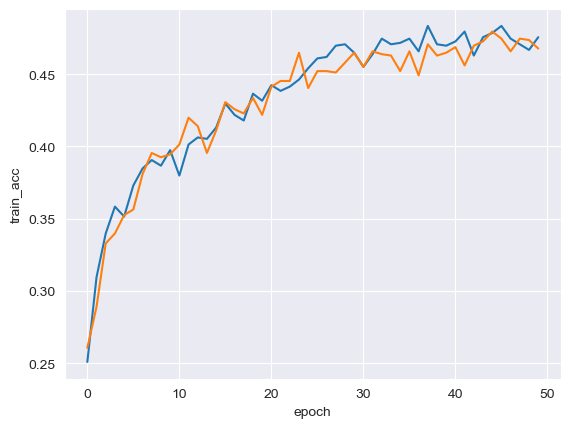

In [50]:
sns.lineplot(res, x = 'epoch', y = 'train_acc')
sns.lineplot(res, x = 'epoch', y = 'val_acc');

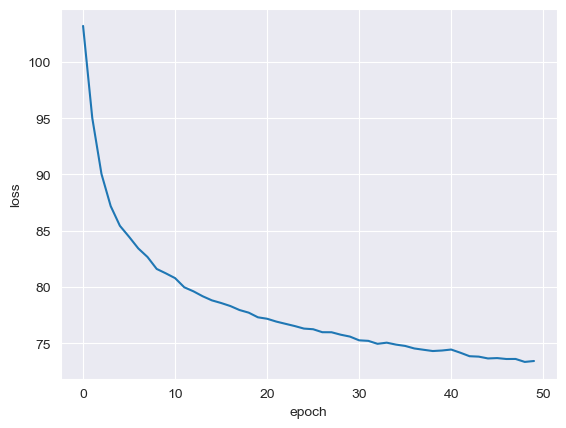

In [53]:
sns.lineplot(res, x = 'epoch', y = 'loss');

In [25]:
%timeit check_accuracy(model, loader_gpu['val'])

17.5 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


18.1 ms ± 4.05 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
